In [32]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

#from MEM_class import MEM

#from synthData_Gen import SyntheticData_Gen

Load all cores available.

In [33]:
milcent = pd.read_csv('../Data/datasets/Milcent/milcent1973detail.txt', ',')[1:]

crete = pd.read_csv('../Data/datasets/Alphabet_cores/crete_det.txt',' ')[1:]

SiteA = pd.read_csv('../Data/datasets/Alphabet_cores/AlfabetFromBo/SiteA_det.txt', ' ')[1:]
SiteB = pd.read_csv('../Data/datasets/Alphabet_cores/AlfabetFromBo/SiteB_det.txt', ' ')[1:]
SiteD = pd.read_csv('../Data/datasets/Alphabet_cores/AlfabetFromBo/SiteD_det.txt', ',')[1:]
SiteE = pd.read_csv('../Data/datasets/Alphabet_cores/AlfabetFromBo/SiteE_det.txt', ' ')[1:]
SiteF = pd.read_csv('../Data/datasets/Alphabet_cores/AlfabetFromBo/SiteF_det.txt', ',')[1:]
SiteG = pd.read_csv('../Data/datasets/Alphabet_cores/AlfabetFromBo/SiteG_det.txt', ' ')[1:]
SiteH = pd.read_csv('../Data/datasets/Alphabet_cores/AlfabetFromBo/SiteH_det.txt', ',')[1:]

B19 = pd.read_csv('../Data/datasets/B_cores_AWI/AWI_Bcores__Cleaned_CSV/Depth_d18O__B19.txt', '\t')
B22 = pd.read_csv('../Data/datasets/B_cores_AWI/AWI_Bcores__Cleaned_CSV/Depth_d18O__B22.txt', '\t')
B23 = pd.read_csv('../Data/datasets/B_cores_AWI/AWI_Bcores__Cleaned_CSV/Depth_d18O__B23.txt', '\t')


#AllData = {'milcent': milcent, 'crete': crete, 'SiteA': SiteA, 'SiteB': SiteB, 'SiteD': SiteD, \
#          'SiteE': SiteE, 'SiteF': SiteF, 'SiteG': SiteG, 'SiteH': SiteH, 'B19': B19, 'B22': B22, 'B23': B23}

AllData = {'crete': crete, 'SiteA': SiteA, 'SiteB': SiteB, 'SiteD': SiteD, \
          'SiteE': SiteE, 'SiteG': SiteG, 'B19': B19, 'B22': B22, 'B23': B23}

CoreNames = ['crete','SiteA','SiteB','SiteD','SiteE','SiteG','B19','B22','B23']
CoreColors = ['slategray','indianred', 'orangered','darkslategray', 'slategray', 'cadetblue', 'darkseagreen', 'tan', 'rosybrown']

Plot cores

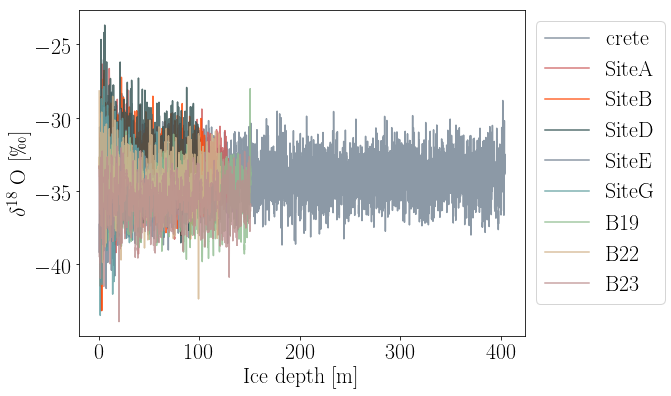

In [34]:
figCores, axCores = plt.subplots(figsize=(8,6))

for core, col in zip(CoreNames, CoreColors):
    axCores.plot(AllData[core]['depth'], AllData[core]['d18O'], alpha = 0.8,color=col, label = core)
    
axCores.set(xlabel='Ice depth [m]', ylabel='$\delta ^{18}$ O [\permil]')
axCores.legend(bbox_to_anchor=(1,1))

Define the min and max values corresponding to Laki and Tambora depth in core.

In [35]:
valsMin = [64.70, 70.90, 73.00, 81.50, 53.40, 60.50, 32.58, 45.44, 39.48]
valsMax = [74.74, 80.85, 83.70, 93.80, 62.95, 69.40,37.12, 52.04, 45.38]

Compute a new depth array with evenly spaced entries through interpolation. New sampling size corresponds to smallest sample size in examined series.

Plot the cores and their interpolations with the same starting point (at x = 0).

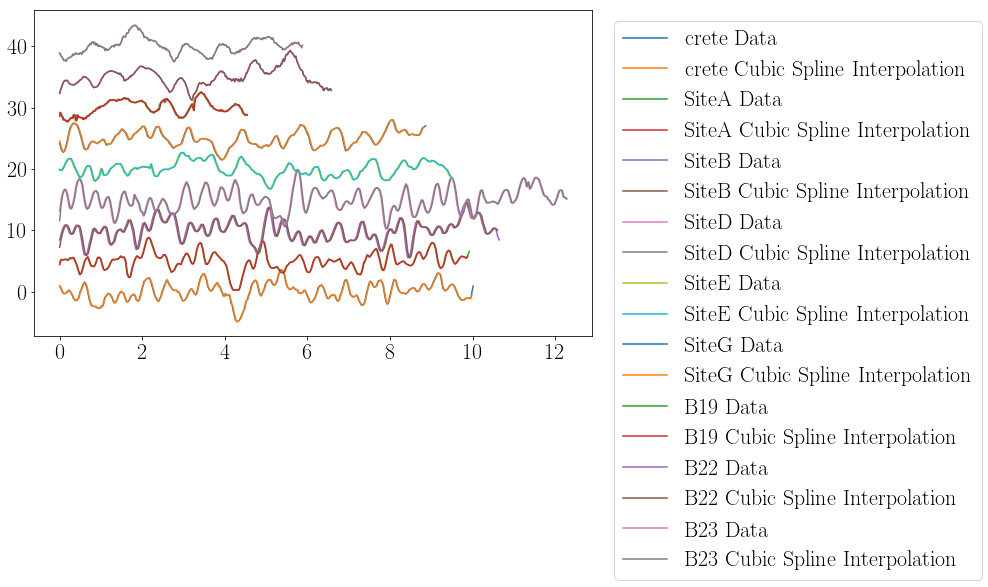

In [36]:
from scipy import interpolate

def interpCores(valMin, valMax, d_in, x_in):
    d = d_in[(d_in >= valMin) & (d_in <= valMax)]
    x = x_in[(d_in >= valMin) & (d_in <= valMax)]
    
    diff = np.diff(d)
    Delta = round(min(diff), 3)
    
    d_min = Delta * np.ceil(d.values[0]/Delta)
    d_max = Delta * np.floor(d.values[-1]/Delta)

    n = int(1 + (d_max - d_min)/Delta)
    
    j_arr = np.linspace(0,n,n)
    dhat = d_min + (j_arr - 1)*Delta
    
    f = interpolate.CubicSpline(d,x)
    
    xhat = f(dhat)
    
    return dhat, xhat

fig, ax = plt.subplots(figsize=(10,6))
add = np.array([0,5,10,15,20,25, 30, 35, 40])
for core, i in zip(CoreNames, range(len(CoreNames))):
    depthUse = AllData[core]['depth'] 
    d18OUse = AllData[core]['d18O']
    
    dhat, xhat = interpCores(valsMin[i], valsMax[i], depthUse, d18OUse)
    
    d18O_int = xhat - np.mean(xhat) + add[i]
    dep_int = dhat
    dep_int = dep_int - dep_int[0]
    
    d18O_U =  d18OUse[(depthUse >= valsMin[i]) & (depthUse <= valsMax[i])]#data['d18O'][(data['depth'] > valMin) & (data['depth'] < valMax)]
    d18O = d18O_U - np.mean(d18O_U) + add[i]
    dep = depthUse[(depthUse >= valsMin[i]) & (depthUse <= valsMax[i])]#data['depth'][(data['depth'] > valMin) & (data['depth'] < valMax)]
    dep = dep - dep.values[0]

    ax.plot(dep, d18O, label=core + ' Data')
    ax.plot(dep_int, d18O_int, label=core + ' Cubic Spline Interpolation')
    ax.legend()
ax.legend(bbox_to_anchor=(1.02,1), loc='upper left')
#ax.set(xlim=(min(valsMin), max(valsMax)));

Define what core to look at - along with its Laki and Tambora locations.

In [37]:
coreName = 'SiteA'
idx = CoreNames.index(coreName)
valMin = valsMin[idx]
valMax = valsMax[idx]

dhat, xhat = interpCores(valsMin[idx], valsMax[idx], AllData[coreName]['depth'], AllData[coreName]['d18O'])

data_in = xhat - np.mean(xhat)
depth_in = dhat


depth = np.asarray(AllData[coreName]['depth'])#s1[4]#
depthLT = depth[(depth >= valMin) & (depth <= valMax)]
#depth_in = depth[(depth >= valMin) & (depth <= valMax)]

data = np.asarray(AllData[coreName]['d18O'])#s1[5]#
dataLT = data[(depth >= valMin) & (depth <= valMax)]
#data_in = data[(depth >= valMin) & (depth <= valMax)]

dt = depth_in[1] - depth_in[0]
N = data_in.size


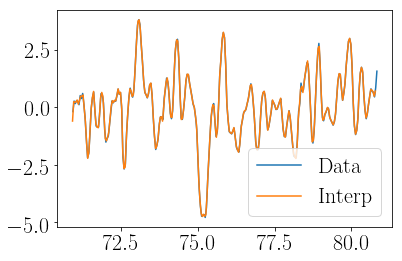

In [38]:


plt.plot(depthLT,dataLT-np.mean(dataLT), label='Data')
plt.plot(depth_in,data_in, label='Interp')
plt.legend()

Create an instance of deconcolution of data

In [49]:
from Decon import SpectralDecon

decon_inst = SpectralDecon(depth_in, data_in, 8000)

Create and plot spectrum figure and axis.

In [50]:
a,b = decon_inst.plotSpectrum(showFig=False)


Using default boundaries for variance and a1
Diff. len., fit [cm]: 7.332


Show spectrum figure

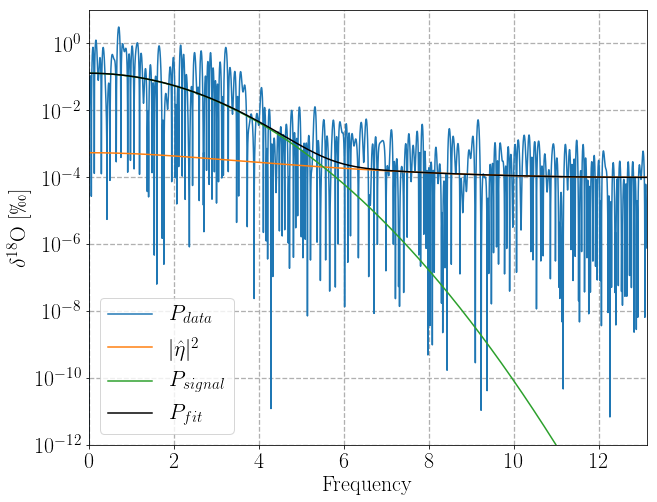

In [51]:
a

Create a list of different diffusion lengths to deconvolve with.

In [52]:
sigma_maxs = {'crete': 0.07647320522992593, 'SiteA': 0.07542018083096282, 'SiteB': 0.0730251883299818,\
              'SiteD': 0.07215903400187486, 'SiteE': 0.0840286812484305, 'SiteG': 0.08047856730788001,\
              'B19': 0.11275453127730335, 'B22': 0.09759582797686535, 'B23': 0.10539522109785524}

sigma_mins = {'crete': 0.07420159383464801, 'SiteA': 0.07318047765033527, 'SiteB': 0.07079314823632839,\
              'SiteD': 0.0700349248758044, 'SiteE': 0.08162470450618413, 'SiteG': 0.07823311448379731,\
              'B19': 0.11131379189684477, 'B22': 0.0952147815586007, 'B23': 0.10312400469656192}

In [53]:
sigma_max = sigma_maxs[coreName]
sigma_min = sigma_mins[coreName]

sigma_in = np.linspace(sigma_min-0.03,sigma_max+0.01,10)
sigma_in

array([0.04318048, 0.04787378, 0.05256708, 0.05726038, 0.06195368,
       0.06664698, 0.07134028, 0.07603358, 0.08072688, 0.08542018])

Compute the filters given the certain diffusion length.

In [54]:
c = []

for i in range(len(sigma_in)):
    c.append(decon_inst.Filters(sigma=sigma_in[i]))


Plot filters for all different diffusion lengths.

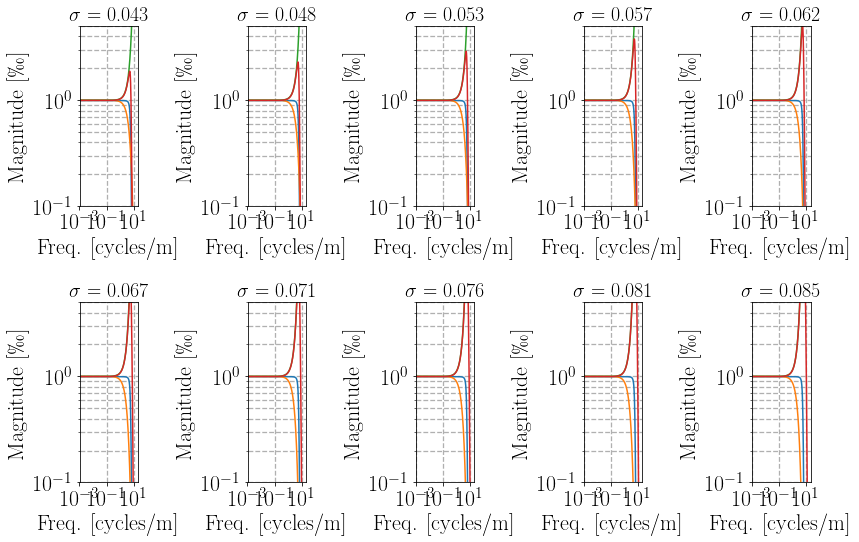

In [55]:
fig, axes = plt.subplots(2,5,figsize=(12,8))
plt.rcParams.update({'font.size': 22})

axes.titlesize:'x-large'
axes.labelsize:'large'
#plt.rcParams.update({'title.size': 18})
for i, ax in zip(range(len(sigma_in)), axes.flatten()):
    ax.grid(linestyle='--',lw=1.3, which='both')
    ax.loglog(c[i][0], c[i][1])
    ax.loglog(c[i][0], c[i][2])
    ax.loglog(c[i][0], c[i][2]**(-1))
    ax.loglog(c[i][0], c[i][3])
    ax.set_title('$\sigma$ = ' + str(round(sigma_in[i],3)),fontsize=20)
    ax.set(ylim=(1e-1,5), xlabel='Freq. [cycles/m]', ylabel='Magnitude [\permil]')
    

#ax.legend(labels= ['$\phi$', '$M$', '$M^{-1}$', '$R = \phi \cdot M^{-1}$'],bbox_to_anchor=(1,1.4), fontsize=20)
fig.tight_layout()

Compute the deconvoluted restored data for each sigma.

In [56]:
e = []

for i in range(len(sigma_in)):
    e.append(decon_inst.deconvolve(sigma=sigma_in[i]))


Plot all restored data given certain diff. len.

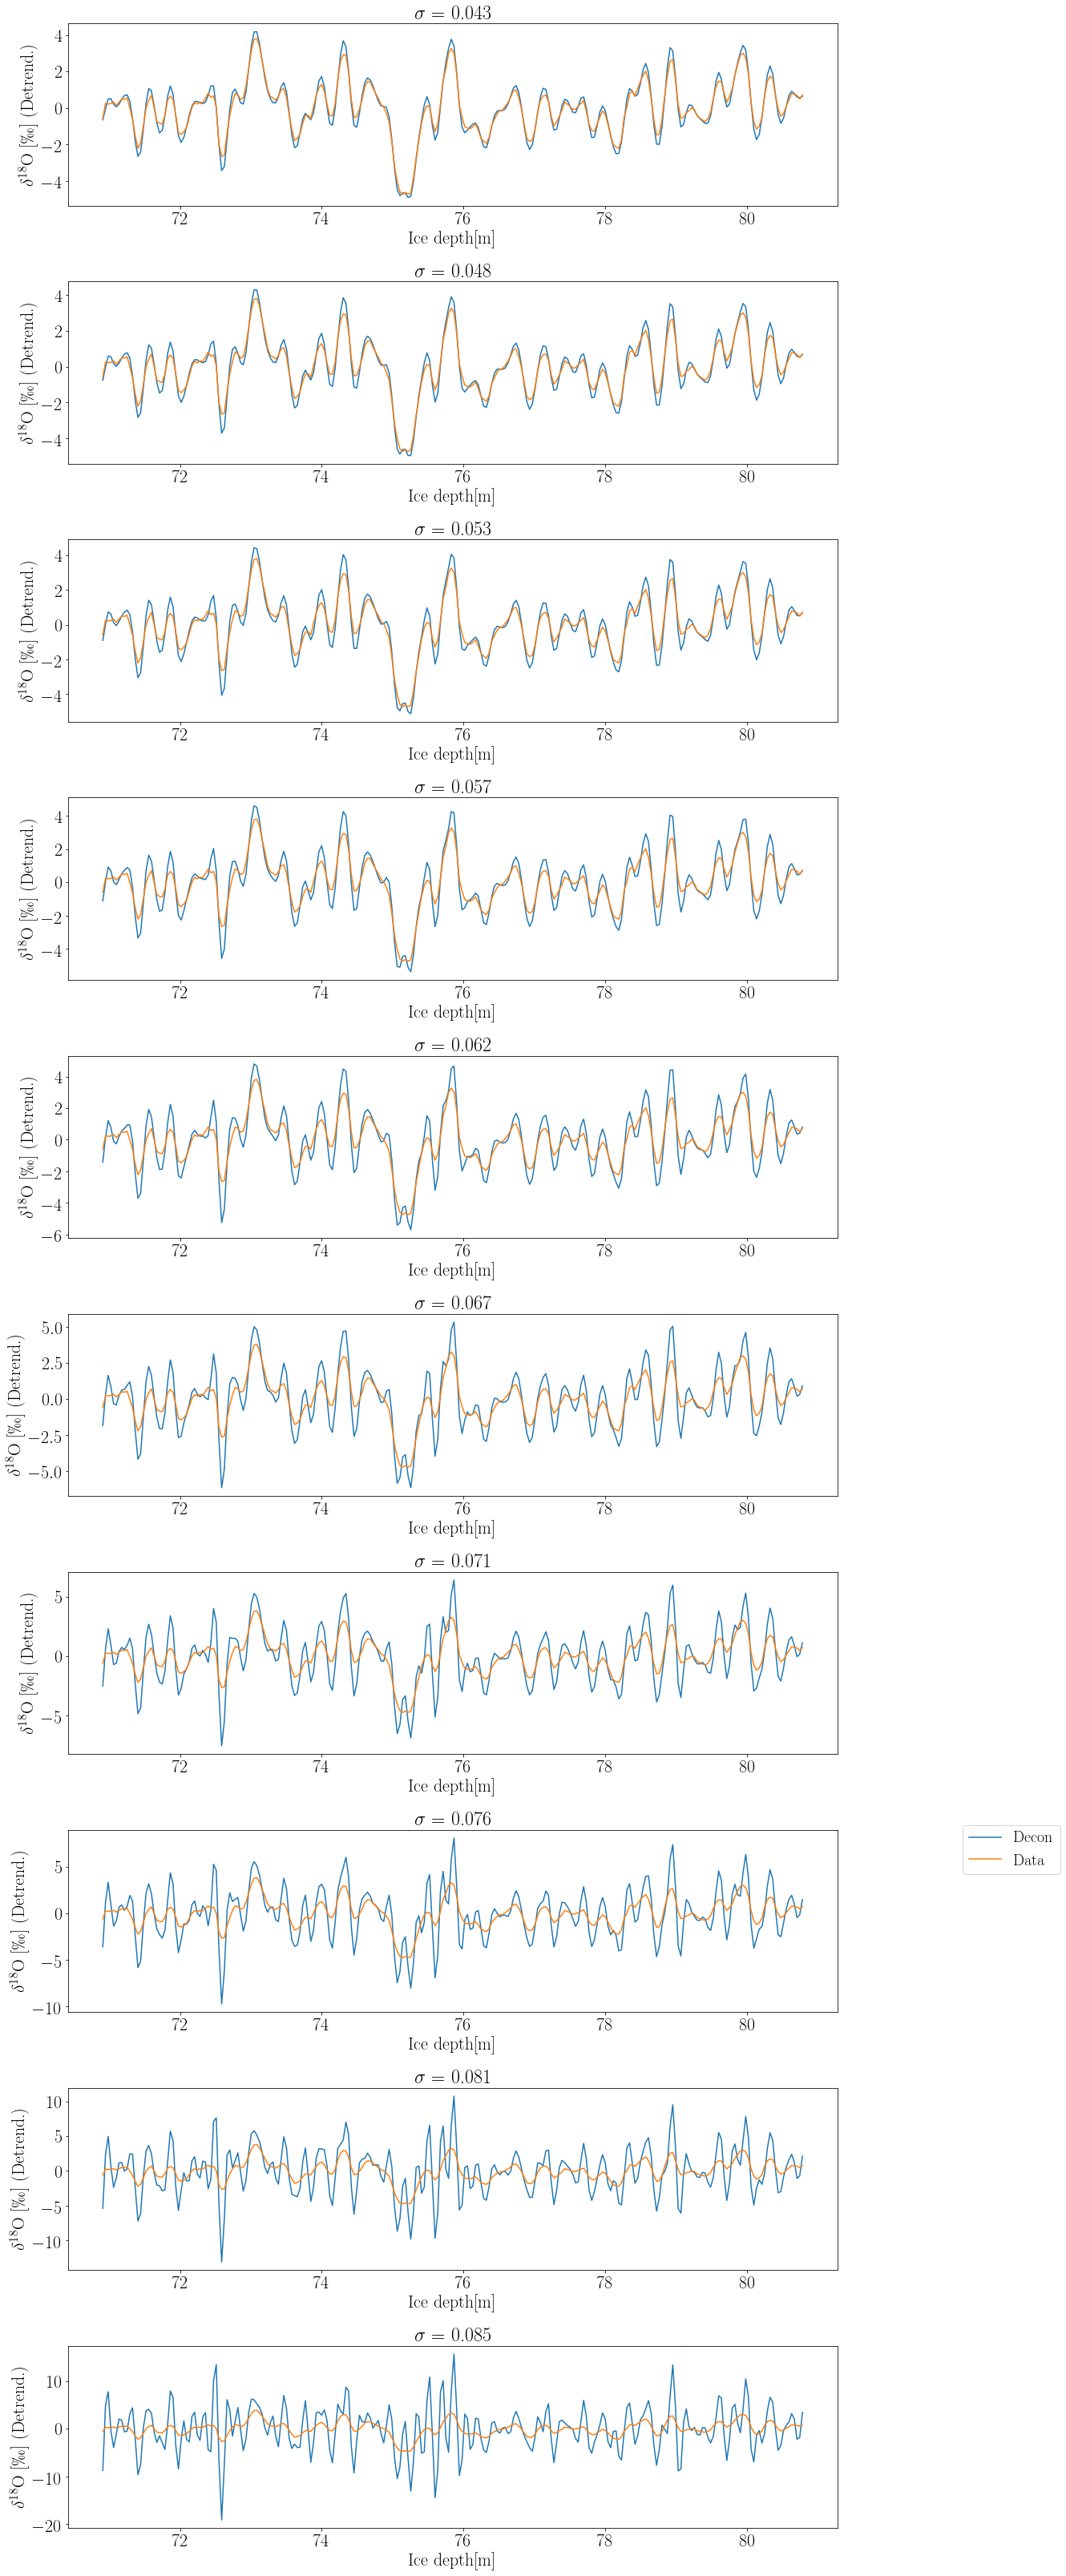

In [57]:
figDecon, axesDecon = plt.subplots(10,1,figsize=(15,45))
plt.rcParams.update({'font.size': 18})
axes.titlesize:'x-large'

for i, ax in zip(range(len(sigma_in)), axesDecon.flatten()):
    ax.plot(e[i][0], e[i][1])
    ax.plot(depth_in, data_in-np.mean(data_in))
    ax.set_title('$\sigma$ = ' + str(round(sigma_in[i],3)),fontsize=24)
    ax.set(xlabel='Ice depth[m]', ylabel='$\delta ^{18}$O [\permil] (Detrend.)')
    

ax.legend(labels= ['Decon', 'Data'],bbox_to_anchor=(1.3,3.9), fontsize=20)
figDecon.tight_layout()

Choose which diffusion lengths to actually use.

In [58]:
sigma_in_use = sigma_in[sigma_in < 0.075]


Plot restored signal for all chosen sigma in same plot.

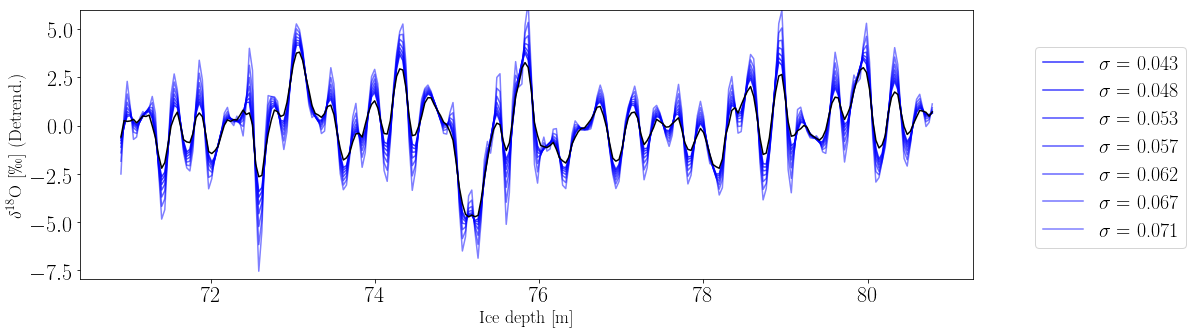

In [59]:
alphas = np.linspace(0.5,0.8,len(sigma_in_use))[::-1]

figDecon1, axDecon1 = plt.subplots(figsize=(14,5))


for i in range(len(sigma_in_use)):
    axDecon1.plot(e[i][0], e[i][1], label='$\sigma = $ ' + str(round(sigma_in_use[i],3)), alpha=alphas[i], color='blue')
axDecon1.plot(depth_in, data_in-np.mean(data_in), color='k')

axDecon1.tick_params(axis='both', which='major', labelsize=22)
axDecon1.set(ylim=(-8,6), xlabel='Ice depth [m]', ylabel='$\delta ^{18}$O [\permil] (Detrend.)')
axDecon1.legend(bbox_to_anchor=(0.75,0.4,0.5,0.5), fontsize=20)
figDecon1.tight_layout()

Generate a time series of synthetic data through an AR1 process:

In [19]:
#s1_instance = SyntheticData_Gen(AR1_coef = 0.3, AR1_var = 120, AR1_dt = 0.001, AR1_N = 20000, diff_len=0.08, dt_sample = 0.02, meas_noise = 0.03)
#s1 = s1_instance()

Plot said time series, both raw AR1 process and sampled/diffused series.

In [20]:
#plotFig = True
#if plotFig:
#    figSynth, axSynth = plt.subplots(figsize=(12,6))
#    axSynth.set(xlim=(0,20), xlabel='Depth [m]', ylabel='$\delta^{18}$O [\permil]')
#    axSynth.plot(s1[2],s1[3],linewidth=0.8, color='blue', alpha=0.9,label='Before diffusion')
#    axSynth.plot(s1[4],s1[5], color='black', label='After diffusion')
#    axSynth.legend()
#    figSynth.savefig('SynthData.png')

Plot only the sampled/diffused data.

In [21]:
#if plotFig:
#    figSynthDiff, axSynthDiff = plt.subplots(figsize=(12,6))
#    axSynthDiff.set(xlim=(0,20), xlabel='Depth [m]', ylabel='$\delta^{18}$O [\permil]', title='Synthetic data, after diffusion')
#    axSynthDiff.plot(s1[4],s1[5], color='black')
#

Estimate of annual cycle length for given signal

In [153]:
import sigma
from sigma import SigmaToolbox
import HL_AnalyticThea_class
from HL_AnalyticThea_class import HL_Thea

In [116]:
def interpCores(valMin, valMax, d_in, x_in):
    d = d_in[(d_in >= valMin) & (d_in <= valMax)]
    x = x_in[(d_in >= valMin) & (d_in <= valMax)]
    
    diff = np.diff(d)
    Delta = round(min(diff), 3)
    
    d_min = Delta * np.ceil(d.values[0]/Delta)
    d_max = Delta * np.floor(d.values[-1]/Delta)

    n = int(1 + (d_max - d_min)/Delta)
    
    j_arr = np.linspace(1,n+1,n)
    dhat = d_min + (j_arr - 1)*Delta
    
    f = interpolate.CubicSpline(d,x)
    
    xhat = f(dhat)
    
    return dhat, xhat

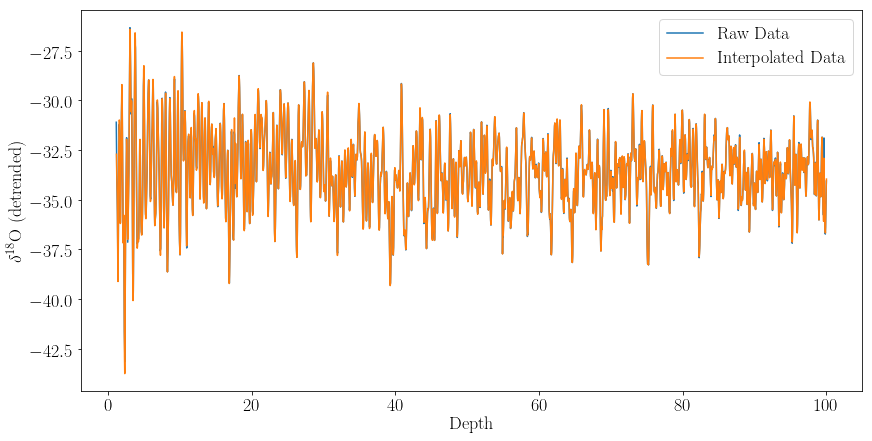

In [251]:
coreName = 'SiteA'
idx = CoreNames.index(coreName)
valMin = 0#valsMin[idx]
valMax = 100#valsMax[idx] - (valsMax[idx] - valsMin[idx])*(1/2)

d_in = AllData[coreName]['depth']
x_in = AllData[coreName]['d18O']
d = d_in[(d_in >= valMin) & (d_in <= valMax)]
x = x_in[(d_in >= valMin) & (d_in <= valMax)]
    

dhat, xhat = interpCores(valMin, valMax, d_in, x_in)


figSignal, axSignal = plt.subplots(figsize=(14,7))
axSignal.plot(d, x, label='Raw Data')
axSignal.plot(dhat, xhat, label='Interpolated Data')

axSignal.set(xlabel='Depth', ylabel='$\delta^{18}$O (detrended)')
axSignal.legend()

In [154]:
siteA_dens = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Analysis/NovemberPresentation__code/Data_November/Site_A_Densities.txt', '\t')
Temp0 = 243.75 # [K]
bdot0 = 0.307#0.267764 # [m W.E.]
dens0 = siteA_dens['rho_measured'][0] # [kg/m^3]
z_vec = siteA_dens['depth']
rho_vec = siteA_dens['rho_measured']

In [155]:
hl_inst = HL_Thea(z_meas = z_vec, rho_meas = rho_vec,\
                     Acc_0 = bdot0, Temp_0 = Temp0, rho_0 = dens0, opti = False)
hl_model = hl_inst.model(z_vec)

hl_instOpti = HL_Thea(z_meas = z_vec, rho_meas = rho_vec,\
                     Acc_0 = bdot0, Temp_0 = Temp0, rho_0 = dens0, opti = True)

hl_modelOpti = hl_instOpti.model(z_vec)
f0 = hl_modelOpti['f0_fin']; f1 = hl_modelOpti['f1_fin']

In [156]:
sigma_inst = SigmaToolbox()
sigma_arr = sigma_inst.experiment2(P = 1, temp = Temp0, accum = bdot0, rho_o = dens0, \
                        fo = f0, f1 = f1, dz = 0.55, z_final = max(z_vec), fileout = False)

0.0 343.46999999999997 0.0
0.55 351.9204270454646 0.0
1.1 360.4480970549122 0.022317040625256437
1.6500000000000001 369.04745299455396 0.03079689783338539
2.2 377.712733319107 0.030090372134588133
2.75 386.4379860883312 0.035968439980654396
3.3000000000000003 395.2170842254659 0.040538796863669714
3.8500000000000005 404.04374184246973 0.04423820982635827
4.4 412.91153154604535 0.043288139141400776
4.95 421.813902628195 0.04630569951354195
5.5 430.74420003567843 0.04884296856266295
6.050000000000001 439.6956840043837 0.0509967765964762
6.6000000000000005 448.66155023739066 0.05283264268009013
7.15 457.6349504995529 0.05440343176567568
7.700000000000001 466.6090134968193 0.05574705128209016
8.25 475.5768659053602 0.05469584092273548
8.8 484.53165341389115 0.05584525562525024
9.350000000000001 493.466561642445 0.05682918158119555
9.9 502.37483680221294 0.05766984686870458
10.450000000000001 511.24980596395955 0.05838375523300131
11.0 520.0848968068337 0.05898703976631863
11.55 528.8736567

91.30000000000001 859.354896661244 0.06579204740340618
91.85000000000001 860.2192707760715 0.06572574283282587
92.4 861.0715273459717 0.0656606899372627
92.95 861.9118110759725 0.0655966768807691
93.50000000000001 862.7402656990184 0.06553388122168656
94.05000000000001 863.5570339579531 0.06547189806138348
94.60000000000001 864.3622575884921 0.06541090567191665
95.15 865.1560773031603 0.06535088821629347
95.7 865.938632776169 0.06529163664820965
96.25000000000001 866.7100626292114 0.0652335227300308
96.80000000000001 867.4705044181502 0.06517633773472438
97.35000000000001 868.2200946205759 0.06512025976799578
97.9 868.9589686242106 0.06506488814656158
98.45 869.6872607161362 0.06501040161371281
99.00000000000001 870.4051040728241 0.064956593552028
99.55000000000001 871.1126307509436 0.06490383513568154
100.10000000000001 871.8099716789249 0.06485192003710118
100.65 872.4972566492596 0.06480083477626034
101.2 873.1746143115134 0.06475075794784277
101.75000000000001 873.8421721660311 0.0

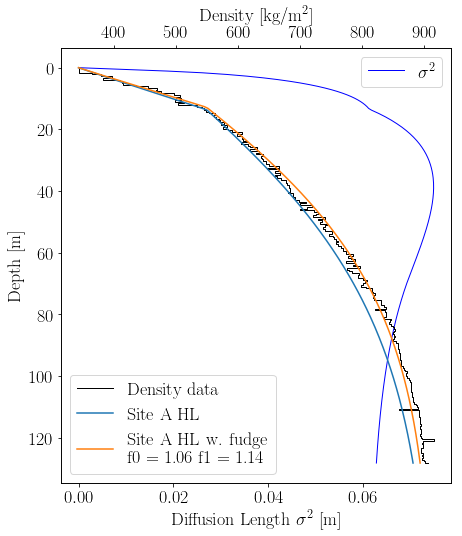

In [189]:
figDiffDens, axDiffDens = plt.subplots(figsize=(7,8))
axDiffDens.invert_yaxis()
axDiffDens.plot(sigma_arr,z_vec, color='blue', lw=1, label='$\sigma^2$')

axDiffDens.set(xlabel='Diffusion Length $\sigma^2$ [m]', ylabel='Depth [m]')
axDiffDens.legend()

axDiffDens2 = axDiffDens.twiny()

axDiffDens2.step(rho_vec,z_vec, lw=1, color='k', label='Density data')
axDiffDens2.plot(hl_model['rhoHL']*1000, z_vec, label='Site A HL')
axDiffDens2.plot(hl_modelOpti['rhoHL']*1000, z_vec, label=f'Site A HL w. fudge\nf0 = {f0:.2f} f1 = {f1:.2f}')
axDiffDens2.set(xlabel='Density [kg/m$^2$]', ylabel='Depth2 [m]')
axDiffDens2.legend()

In [254]:
xhat[dhat>20]

array([-32.57593988, -33.91127652, -35.16914249, ..., -35.1066144 ,
       -34.34450874, -33.96186417])

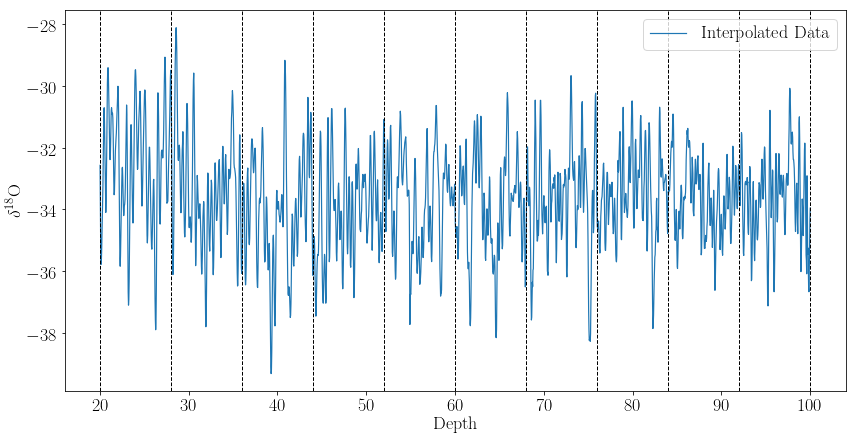

In [273]:
N_secs = 10
test1 = dhat
test2 = xhat
dhat = test1[test1 > 20]
xhat = test2[test1 > 20]
secLen = (dhat.max() - dhat.min())/N_secs

secBounds = [(i*secLen+dhat.min()) for i in range(N_secs+1)]

figSignal, axSignal = plt.subplots(figsize=(14,7))
axSignal.plot(dhat, xhat, label='Interpolated Data',lw=1.2)
axSignal.set(xlabel='Depth', ylabel='$\delta^{18}$O')
for bound in secBounds:
    axSignal.axvline(x=bound,color='k',ls='--',lw=1)
axSignal.legend()


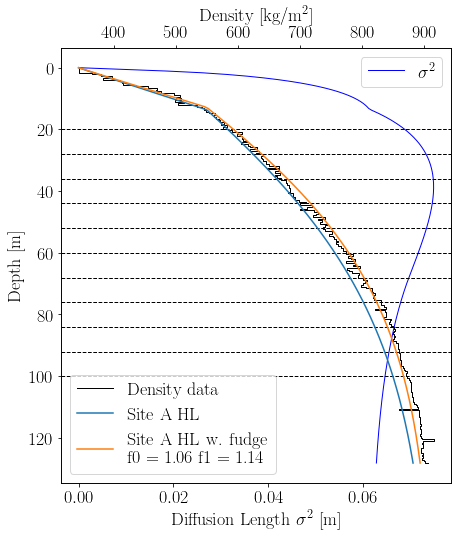

In [274]:
figDiffDens, axDiffDens = plt.subplots(figsize=(7,8))
axDiffDens.invert_yaxis()
axDiffDens.plot(sigma_arr,z_vec, color='blue', lw=1, label='$\sigma^2$')

axDiffDens.set(xlabel='Diffusion Length $\sigma^2$ [m]', ylabel='Depth [m]')
axDiffDens.legend()

axDiffDens2 = axDiffDens.twiny()

axDiffDens2.step(rho_vec,z_vec, lw=1, color='k', label='Density data')
axDiffDens2.plot(hl_model['rhoHL']*1000, z_vec, label='Site A HL')
axDiffDens2.plot(hl_modelOpti['rhoHL']*1000, z_vec, label=f'Site A HL w. fudge\nf0 = {f0:.2f} f1 = {f1:.2f}')

diffAves = []
for bound in secBounds:
    axDiffDens.axhline(y=bound,color='k',ls='--',lw=1)

axDiffDens2.set(xlabel='Density [kg/m$^2$]', ylabel='Depth2 [m]')
axDiffDens2.legend()

In [276]:
diffAves = np.zeros(len(secBounds)-1)
sigma_arr[(z_vec > secBounds[0]) & (z_vec < secBounds[0+1])]
for i in range(len(secBounds)-1):
    diffAves[i] = np.average(sigma_arr[(z_vec > secBounds[i]) & (z_vec < secBounds[i+1])])
diffAves

array([0.07128806, 0.07415626, 0.0747574 , 0.07399519, 0.0724821 ,
       0.0706052 , 0.06872278, 0.06718553, 0.06597186, 0.06500848])

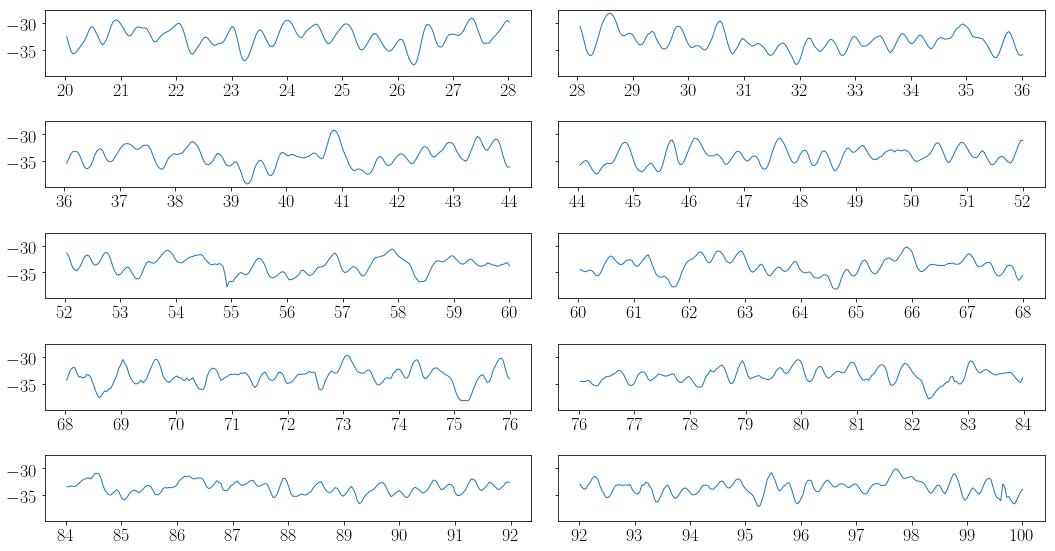

In [277]:
figSec, axSec = plt.subplots(5,2, figsize=(15,8), sharey=True)

for i,ax in zip(range(len(secBounds)), axSec.flatten()):
    ax.plot(dhat[(dhat>=secBounds[i]) & ((dhat<=secBounds[i+1]))], xhat[(dhat>=secBounds[i]) & ((dhat<=secBounds[i+1]))], lw=1)
    

figSec.tight_layout()

In [278]:
#decon_inst = SpectralDecon(dhat, xhat,len(xhat)/3)
#a1,b1 = decon_inst.plotSpectrum(showFig=False)
#a1

In [303]:
i = 9
decon_inst = SpectralDecon(dhat[(dhat>=secBounds[i]) & ((dhat<=secBounds[i+1]))], xhat[(dhat>=secBounds[i]) & ((dhat<=secBounds[i+1]))],2000)
a1,b1 = decon_inst.plotSpectrum(showFig=False)

print(diffAves[i])


Using default boundaries for variance and a1
Diff. len., fit [cm]: 6.879
0.0650084798176122


In [320]:
d_decon = []
x_decon = []
for i in range(len(secBounds)-1):
    decon_inst = SpectralDecon(dhat[(dhat>=secBounds[i]) & ((dhat<=secBounds[i+1]))], xhat[(dhat>=secBounds[i]) & ((dhat<=secBounds[i+1]))],2000)
    c1 = decon_inst.Filters(sigma=diffAves[i])
    d1 = decon_inst.deconvolve(sigma=diffAves[i])
    d_decon.append(d1[0][:])
    x_decon.append(d1[1][:])
    
d_deconC = np.concatenate(d_decon, axis=0)
x_deconC = np.concatenate(x_decon, axis=0)

[Text(0,0.5,'$\\delta^{18}$O'), Text(0.5,0,'Depth')]

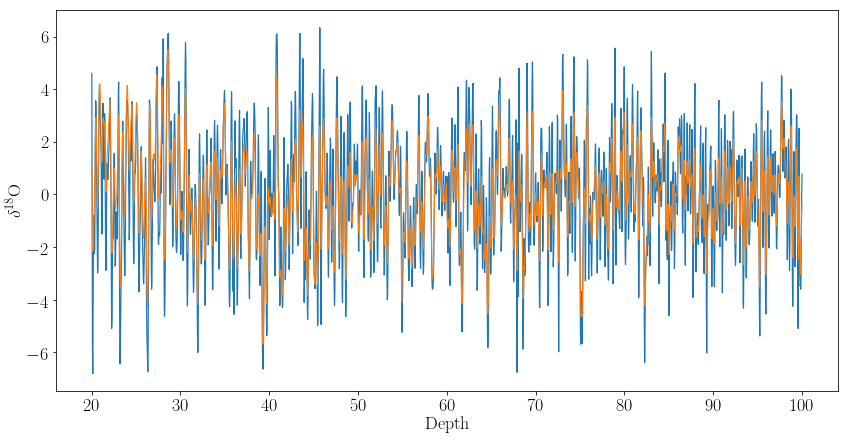

In [325]:

figSignal, axSignal = plt.subplots(figsize=(14,7))
axSignal.plot(d_deconC, x_deconC, label='Deconvoluted Data', lw=1.2)
axSignal.plot(dhat, xhat-np.mean(xhat), label='Interpolated Data',lw=1)
axSignal.set(xlabel='Depth', ylabel='$\delta^{18}$O')




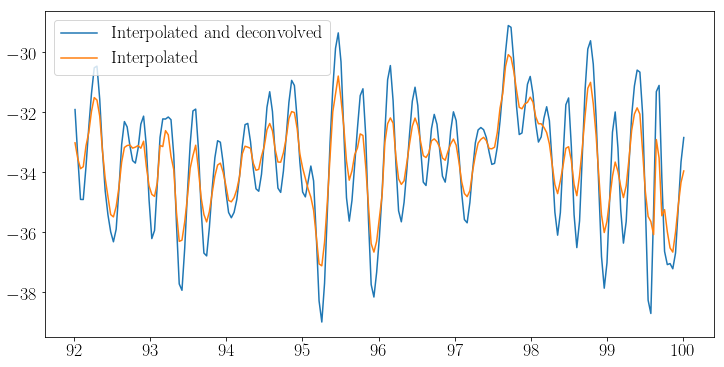

In [304]:
sigmaTest = diffAves[i]

c1 = decon_inst.Filters(sigma=sigmaTest)
d1 = decon_inst.deconvolve(sigma=sigmaTest)


figTest, axTest = plt.subplots(figsize=(12,6))
axTest.plot(d1[0],d1[1]+np.mean(xhat), label='Interpolated and deconvolved')
axTest.plot(dhat[(dhat>=secBounds[i]) & ((dhat<=secBounds[i+1]))], xhat[(dhat>=secBounds[i]) & ((dhat<=secBounds[i+1]))], label='Interpolated')
#axTest.plot(d, x, label='Raw Data')
axTest.legend()

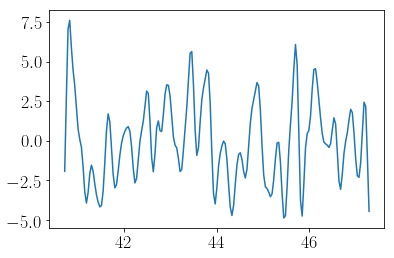

In [233]:
deconSeries = pd.Series(d1[1])
depthSeries = pd.Series(d1[0])
deconWindows = deconSeries.rolling(6)
depthWindows = depthSeries.rolling(6)
deconMovAve = deconWindows.mean()
depthMovAve = depthWindows.mean()
deconMovAve2 = deconSeries#deconMovAve.tolist()[6-1:]
depthMovAve2 = depthSeries#depthMovAve.tolist()[6-1:]

plt.plot(depthMovAve2, deconMovAve2)

In [234]:
#def AutoCorr(depth, signal):
xhat1 = np.asarray(deconMovAve2)
dhat1 = np.asarray(depthMovAve2)
mu = np.mean(xhat1)
sigma = np.std(xhat1)
n = len(xhat1)
maxLag = len(xhat1)
ks = np.arange(0,maxLag-1,1)


S = np.zeros(len(ks))
for k in ks:
    for i in range(1, n - k):
        S[k] += (xhat1[i] - mu)*(xhat1[i+k] - mu)
        
    S[k] *= 1/((n - k)*sigma**2) 
#    return
ks = ks * (dhat1[1]-dhat1[0])


(0, 0.6)

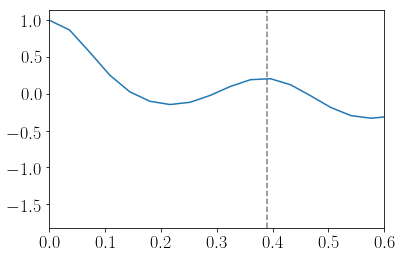

In [236]:

plt.plot(ks,S)
dx = 0.39
plt.axvline(x=dx,color='k', alpha=0.5, ls='--')

plt.xlim((0,0.6))


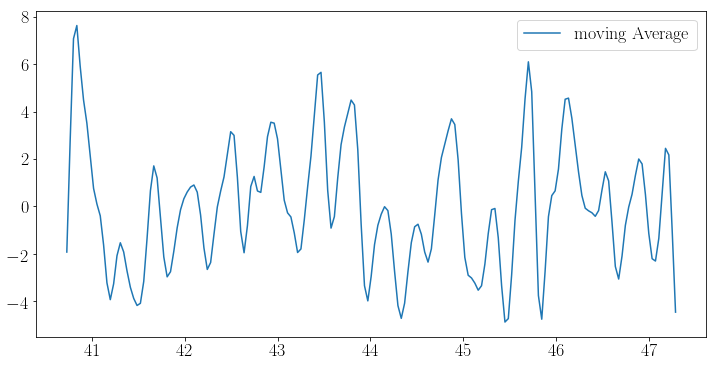

In [237]:
figTest, axTest = plt.subplots(figsize=(12,6))
plt.plot(depthMovAve2, deconMovAve2, label='moving Average')
#axTest.plot(dhat, xhat, label='Interpolated')
#axTest.plot(d, x, label='Raw Data')
axTest.legend()

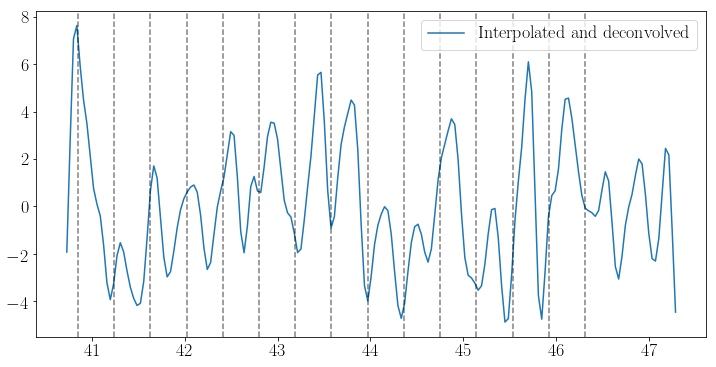

In [241]:
figTest, axTest = plt.subplots(figsize=(12,6))
axTest.plot(d1[0],d1[1], label='Interpolated and deconvolved')
#axTest.plot(dhat, xhat-np.mean(xhat), label='Interpolated')
#axTest.plot(d, x-np.mean(x), label='Raw Data')
peak1 = 40.85

#axTest.axvline(x = peak1,color='k', alpha=0.5, ls='--')
#axTest.axvline(x = peak2,color='k', alpha=0.5, ls='--')
for i in range(15):
    axTest.axvline(x = peak1 + i*dx,color='k', alpha=0.5, ls='--')
#axTest.axvline(x = peak1+xs[1],color='k', alpha=0.5, ls='--')
axTest.legend()